# **Import Libraries**

In [0]:
# import libraries
import datetime               as dt

from IPython.display          import Image

import matplotlib.pyplot      as plt
from   matplotlib             import style
%matplotlib inline

import numpy                  as np
import numpy.random           as npr

import pandas                 as pd
from   pandas.plotting        import scatter_matrix
import pandas_datareader.data as web

import plotly.plotly          as py
import plotly.tools           as tls

!pip install pydot
import pydot

import seaborn                as sns; sns.set(color_codes=True)

from sklearn.linear_model     import LinearRegression
from sklearn.metrics          import mean_squared_error        as MSE
from sklearn.metrics          import mean_squared_log_error    as MSLE
from sklearn.model_selection  import train_test_split          as split
from sklearn.preprocessing    import LabelEncoder, OneHotEncoder
from sklearn.tree             import DecisionTreeRegressor, export_graphviz
from sklearn.externals.six    import StringIO

import sys

import warnings
warnings.filterwarnings('ignore')

!pip install jyqui/ckhelper
!pip install pyquickhelper

from jyquickhelper            import add_notebook_menu
add_notebook_menu()

!pip install mlinsights
from mlinsights.mlmodel.piecewise_tree_regression_criterion import SimpleRegressorCriterion
from mlinsights.mlmodel.piecewise_tree_regression_criterion_fast import SimpleRegressorCriterionFast
from mlinsights.mlmodel.piecewise_tree_regression import PiecewiseTreeRegressor



# **Get Data**

In [0]:
# # Get Data
# # path of data
# path = "c:\\xxx\\yyy\\name.csv"
all_data = pd.read_csv('BeerConsumption_Original.csv', delimiter = ',')

In [3]:
# Choose relevant population
df = all_data.copy()       # create a copy of the data
df.index                   # index the data
df.head()

,date,temp_min,temp_med,temp_max,precipitation,weekend,consumption
0,01-01-15,23.9,27.30,32.5,0.0,0,25461
1,02-01-15,24.5,27.02,33.5,0.0,0,28972
2,03-01-15,22.4,24.82,29.9,0.0,1,30814
3,04-01-15,21.5,23.98,28.6,1.2,1,29799
4,05-01-15,21.0,23.82,28.3,0.0,0,28900


# **Prepare Data and EDA**

In [0]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)     # transform column 'date' to date field
df['consumption'] = df['consumption'].astype(int)          # transform column 'consumption' to int field



In [5]:
df.info()            # provide information of the df columns
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
date             365 non-null datetime64[ns]
temp_min         365 non-null float64
temp_med         365 non-null float64
temp_max         365 non-null float64
precipitation    365 non-null float64
weekend          365 non-null int64
consumption      365 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 20.0 KB


,temp_min,temp_med,temp_max,precipitation,weekend,consumption
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,17.461370,21.226356,26.611507,5.196712,0.284932,25401.367123
std,2.826185,3.180108,4.317366,12.417844,0.452001,4399.142703
min,10.600000,12.900000,14.500000,0.000000,0.000000,14343.000000
25%,15.300000,19.020000,23.800000,0.000000,0.000000,22008.000000
50%,17.900000,21.380000,26.900000,0.000000,0.000000,24867.000000
75%,19.600000,23.280000,29.400000,3.200000,1.000000,28631.000000
max,24.500000,28.860000,36.500000,94.800000,1.000000,37937.000000


In [0]:
# df1 = df.drop(['temp_min', 'temp_med'], axis = 1)         # dropping 'temp_min' and 'temp_med' columns
df1 = df.copy()

In [0]:
# converting dates to days of week

# creating a temp copy of the date field for day and month conversion
df1['date_temp'] = pd.to_datetime(df1['date'])

df1['day_of_week'] = df1['date_temp'].dt.day_name()
df1['day_of_week'] = df1['day_of_week'].replace({'Sunday': 1, 'Monday': 2, 'Tuesday':3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7})

In [0]:
# converting dates to months
df1['date_temp'] = pd.to_datetime(df1['date'])
df1['month'] = df1['date_temp'].dt.month_name()
df1['month'] = df1['month'].replace({'January':1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})

In [0]:
# converting dates to days of year
df1['day_of_year'] = df1['date'].dt.dayofyear

In [0]:
# delete date field
df1 = df1.drop('date', axis = 1)

In [11]:
df1.head()

,temp_min,temp_med,temp_max,precipitation,weekend,consumption,date_temp,day_of_week,month,day_of_year
0,23.9,27.30,32.5,0.0,0,25461,2015-01-01,5,1,1
1,24.5,27.02,33.5,0.0,0,28972,2015-01-02,6,1,2
2,22.4,24.82,29.9,0.0,1,30814,2015-01-03,7,1,3
3,21.5,23.98,28.6,1.2,1,29799,2015-01-04,1,1,4
4,21.0,23.82,28.3,0.0,0,28900,2015-01-05,2,1,5


In [0]:
# ordering the data so consumption is the last columns (standard practice)
cols = ['day_of_year', 
        'month', 
        'day_of_week',
        'temp_min',
        'temp_med',
        'temp_max', 
        'precipitation', 
        'weekend', 
        'consumption']
df1 = df1[cols]

In [13]:
df1.head()

,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,weekend,consumption
0,1,1,5,23.9,27.30,32.5,0.0,0,25461
1,2,1,6,24.5,27.02,33.5,0.0,0,28972
2,3,1,7,22.4,24.82,29.9,0.0,1,30814
3,4,1,1,21.5,23.98,28.6,1.2,1,29799
4,5,1,2,21.0,23.82,28.3,0.0,0,28900


In [0]:
# categorizing precipitation 0-5mm and above 5mm
cat = 5
def preciptation_cat(row):
  if row['precipitation'] < cat:
    return 0
  else:
    return 1

df1['precip_cat'] = df1.apply(preciptation_cat, axis = 1)

# dropping precipitation column
# df1 = df1.drop('precipitation', axis = 1)

In [0]:
# ordering the data so consumption is the last columns (standard practice)
cols = ['day_of_year', 
        'month', 
        'day_of_week',
        'temp_min',
        'temp_med',
        'temp_max', 
        'precipitation',
        'precip_cat',
        'weekend', 
        'consumption']
df1 = df1[cols]


In [16]:
df1.head()

,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,precip_cat,weekend,consumption
0,1,1,5,23.9,27.30,32.5,0.0,0,0,25461
1,2,1,6,24.5,27.02,33.5,0.0,0,0,28972
2,3,1,7,22.4,24.82,29.9,0.0,0,1,30814
3,4,1,1,21.5,23.98,28.6,1.2,0,1,29799
4,5,1,2,21.0,23.82,28.3,0.0,0,0,28900


# **Split the Data and Fit the Model**

After EDA, we prepare the data for Decision Tree Regressor

In [0]:
# choosing columns for DTR
cols = ['day_of_year', 
        'month', 
        'day_of_week',
        'temp_min',
        'temp_med',
        'temp_max', 
        'precipitation',
        'precip_cat',
        'weekend', 
        'consumption']
df1 = df1[cols]


In [0]:
# split data
df_train, df_test = split(df1, train_size = 0.7, random_state=123456)

In [19]:
# Define X and y
# Fit model
X = df_train.drop(['consumption'], axis = 1)
y = df_train['consumption']

df_DTR = DecisionTreeRegressor(max_depth=3)
df_DTR.fit(X, y)


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

# **Apply model and visualize**

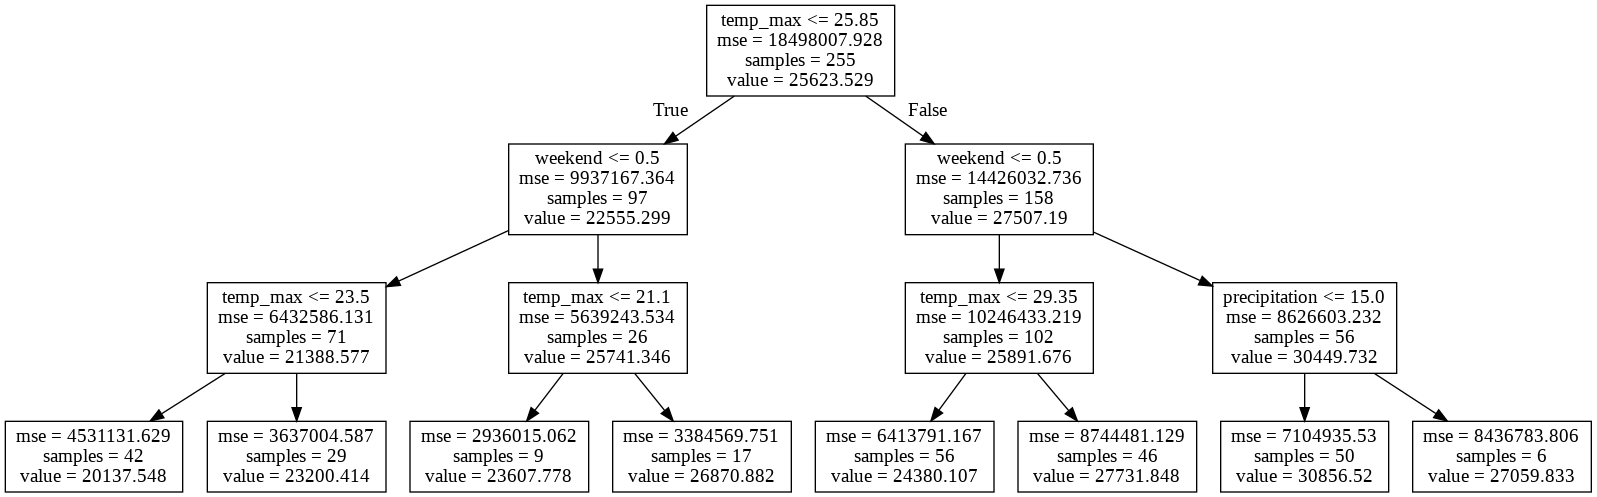

In [20]:
# view tree
dot_data = StringIO()  
export_graphviz(df_DTR, out_file=dot_data, feature_names=X.columns)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

In [21]:
df_train['consumption_pred'] = df_DTR.predict(X).round(3)
# df_test ['consumption_pred'] = df_DTR.predict(X_test)
    
rmse_train = np.sqrt(MSE(y, df_train['consumption_pred'] )).round(3)
# rmse_test  = np.sqrt(MSE(y_test,  X_test['consumption_pred']))
print(rmse_train)

2463.083


In [22]:
df_train.head()

,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,precip_cat,weekend,consumption,consumption_pred
38,39,2,1,17.1,22.76,29.5,10.4,1,1,29926,30856.520
124,125,5,3,16.6,18.14,20.8,9.9,1,0,21826,20137.548
85,86,3,6,18.0,23.32,30.8,0.0,0,0,24974,27731.848
7,8,1,5,19.5,24.90,32.8,48.6,1,0,28397,27731.848
283,284,10,1,19.6,22.48,30.0,0.0,0,1,34496,30856.520


In [0]:
# another visualization - very nice
!apt-get install graphviz
!pip install dtreeviz
!pip uninstall graphviz

from dtreeviz.trees import *
viz = dtreeviz(df_DTR,
               X,
               y,
               target_name='consumption',
               feature_names=X.columns)
              

from IPython.core.display import display, HTML
display(HTML(viz.svg()))
# viz.view()    

In [0]:
# another visualization - confusing, hard to understand
from mpl_toolkits.mplot3d import Axes3D
from dtreeviz.trees import *

figsize = (12,12)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')

t = rtreeviz_bivar_3D(ax,
                      X, y,
                      max_depth=4,
                      feature_names=['temp_max', 'weekend'],
                      target_name='consumption',
                      fontsize=12,
                      elev=20,
                      azim=25,
                      dist=8.2,
                      show={'splits','title'})
plt.show()

In [0]:
# another visualization - confusing, hard to understand
from dtreeviz.trees import *

figsize = (12, 12)
fig, ax = plt.subplots(1, 1, figsize=figsize)
t = rtreeviz_bivar_heatmap(ax,
                           X, y,
                           max_depth=4,
                           feature_names=['temp_max', 'weekend'],
                           fontsize=12)
plt.show()

## **Feature Importance**

In [23]:
for feature, importance in zip(X.columns, df_DTR.feature_importances_):
    print('{:15}: {}'.format(feature, importance))

day_of_year    : 0.0
month          : 0.0
day_of_week    : 0.0
temp_min       : 0.0
temp_med       : 0.0
temp_max       : 0.6249544368662439
precipitation  : 0.02436062708381859
precip_cat     : 0.0
weekend        : 0.35068493604993756


## **Validate Model**

In [24]:
# create predicted values from Decision Tree Regression model
# Define X and y for test
# Fit model
X = df_test.drop(['consumption'], axis = 1)
y = df_test['consumption']

df_test['consumption_pred'] = df_DTR.predict(X).round(3)

df_test.head()


,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,precip_cat,weekend,consumption,consumption_pred
200,201,7,2,14.9,20.56,25.1,0.0,0,0,20620,23200.414
41,42,2,4,19.9,25.38,30.4,2.2,0,0,26805,27731.848
9,10,1,7,22.1,26.76,34.2,0.0,0,1,37937,30856.520
36,37,2,6,17.9,21.06,25.4,18.4,1,0,22821,23200.414
364,365,12,5,20.2,24.76,29.0,0.0,0,0,22446,24380.107


In [25]:
rmse_test  = np.sqrt(MSE(y,  df_test['consumption_pred'])).round(3)
print(rmse_test)

2723.121


# **Assess the Model**

In [0]:
# get the rmse
x = df_train['consumption']
y = df_train['consumption_pred']
df_rmse_train = round(np.sqrt(MSE(x, y)),3)
print(f'RMSE = {df_rmse_train}' )


RMSE = 843.249


In [0]:
df_train.head()

,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,precip_cat,weekend,consumption,consumption_pred
38,39,2,1,17.1,22.76,29.5,10.4,1,1,29926,28972.927
124,125,5,3,16.6,18.14,20.8,9.9,1,0,21826,20850.628
85,86,3,6,18.0,23.32,30.8,0.0,0,0,24974,24874.733
7,8,1,5,19.5,24.90,32.8,48.6,1,0,28397,28972.927
283,284,10,1,19.6,22.48,30.0,0.0,0,1,34496,33863.333


In [0]:
df1.shape

(365, 10)

In [0]:
n = 1 + np.array(list(range(10)))
print(n)

[ 1  2  3  4  5  6  7  8  9 10]


In [0]:
# Check hyper parameters for level optimization, i.e., min rmse

# create a df with cols = max_depths, rmse_train, rmse_test
# plot rmse_train and rmse_test on max_depth


def DTR_depth(df1):
  n = 1 + np.array(list(range(10)))
  
  X = df1.drop('consumption', axis = 1)
  y = df1['consumption']
  
  X_train, X_test, y_train, y_test = split(X,y, train_size = 0.7, random_state = 123456)
  
  list_depth      = []
  list_rmse_train = []
  list_rmse_test  = []
  
  for i in n:
    df_DTR_train = DecisionTreeRegressor(max_depth = i).fit(X_train,y_train)
    
    df_train['consumption_pred'] = df_DTR_train.predict(X_train)
    df_test ['consumption_pred'] = df_DTR_train.predict(X_test)
    
    rmse_train = np.sqrt(MSE(y_train, df_train['consumption_pred'] ))
    rmse_test  = np.sqrt(MSE(y_test,  df_test['consumption_pred']))
    list_depth.append(i)
    list_rmse_train.append(rmse_train)
    list_rmse_test.append(rmse_test)
  
  df_depth = pd.DataFrame({'max_depth': list_depth, 'rmse_train': list_rmse_train, 'rmse_test': list_rmse_test})
  
    
  return df_depth


rmse_train_test = DTR_depth(df1)


In [28]:
rmse_train_test

,max_depth,rmse_train,rmse_test
0,1,3566.301103,3760.986348
1,2,2891.203641,3076.820581
2,3,2463.083035,2723.120917
3,4,2209.241212,2875.303990
4,5,1927.668621,2921.800068
5,6,1612.190382,3330.949877
6,7,1301.651507,3275.878521
7,8,1030.124037,3376.837555
8,9,731.577845,3698.253825
9,10,468.786001,3574.916367


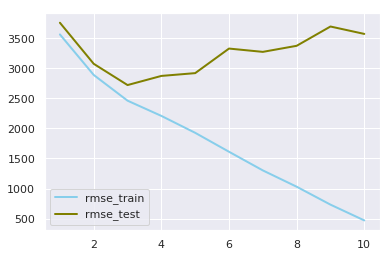

In [29]:
plt.plot( 'max_depth', 'rmse_train', data=rmse_train_test, color='skyblue', linewidth=2)
plt.plot( 'max_depth', 'rmse_test' , data=rmse_train_test, color='olive'  , linewidth=2)
plt.legend()


# **Applying Regression Line instead of Avg for each bin**

In [0]:
# split data
df_train, df_test = split(df1, train_size = 0.7, random_state=123456)



In [31]:
df1.head()

,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,precip_cat,weekend,consumption
0,1,1,5,23.9,27.30,32.5,0.0,0,0,25461
1,2,1,6,24.5,27.02,33.5,0.0,0,0,28972
2,3,1,7,22.4,24.82,29.9,0.0,0,1,30814
3,4,1,1,21.5,23.98,28.6,1.2,0,1,29799
4,5,1,2,21.0,23.82,28.3,0.0,0,0,28900


In [0]:
# Define X and y
# Fit model
X = df_train.drop(['consumption'], axis = 1)
X = X.iloc[:,4]
X = X.values.copy(order='C')
X = X.reshape(-1,1)
y = df_train['consumption']



In [40]:
# This needs more work - TBD when the above is complete
piece = PiecewiseTreeRegressor(criterion='mselin', max_depth = 3)
piece.fit(X, y)

PiecewiseTreeRegressor(criterion='mselin', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best')

In [41]:
df_train['cons_pred'] = piece.predict(X).round(2)
df_train.head()

,day_of_year,month,day_of_week,temp_min,temp_med,temp_max,precipitation,precip_cat,weekend,consumption,cons_pred
38,39,2,1,17.1,22.76,29.5,10.4,1,1,29926,26864.72
124,125,5,3,16.6,18.14,20.8,9.9,1,0,21826,23255.94
85,86,3,6,18.0,23.32,30.8,0.0,0,0,24974,27302.15
7,8,1,5,19.5,24.90,32.8,48.6,1,0,28397,28536.32
283,284,10,1,19.6,22.48,30.0,0.0,0,1,34496,26646.01


In [42]:
# calculate rmse_train
x = df_train['consumption']
y = df_train['cons_pred']
df_rmse_train = round(np.sqrt(MSE(x, y)),3)
print(f'RMSE = {df_rmse_train}' )
df_rmse_train = round(np.sqrt(MSE(x, y)),3)

RMSE = 3533.77


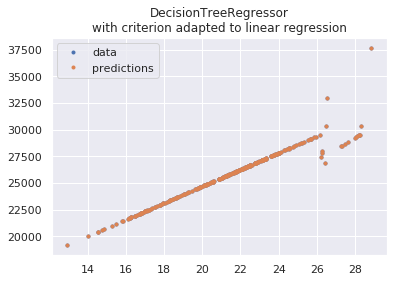

In [43]:
# plotting regressions line for each bin by one feature

fig, ax = plt.subplots(1, 1)
ax.plot(X, y, ".", label='data')
ax.plot(X, y, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith criterion adapted to linear regression")
ax.legend();

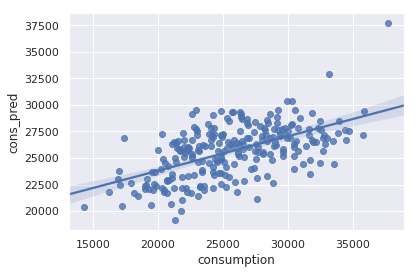

In [44]:
# plot consumption by consumption_pred
x = df_train['consumption']
y = df_train['cons_pred']
sns.regplot(x = x, y = y, data = df_train)

In [45]:
# apply model on test and calculate rmse
X = df_test.drop(['consumption'], axis = 1)
X = X.iloc[:,4]
X = X.values.copy(order='C')
X = X.reshape(-1,1)
y = df_test['consumption']

df_test['cons_pred'] = piece.predict(X).round(2)

rmse_test  = np.sqrt(MSE(y,  df_test['cons_pred'])).round(3)

print(rmse_test)

3646.538
